# Calculate atmospheric river anomaly regime composite pattern correlations between ERA5 and Metis

Calculates the AR anomaly correlations for each regime in ERA5 and Metis. Borrows pattern correlation method from pattern_correlation_matrix.ipynb

* ERA5 Input: `/glade/work/mkorendy/metisregimes/era5.AR.10%.PNA.months.k#.composite.nc`

* Metis Input: `/glade/work/mkorendy/metisregimes/resolution/data.AR.10%.PNA.months.k#.composite.nc`

* Correlation output: `data.AR.10%.PNA.months.k#.correlation.png`

* Summary output: `data.AR.10%.PNA.months.k#.correlation_summary.png`

## Pattern Correlation Method

In [1]:
def PattCorr(ds_met, ds_comp, ds_coslat):    
    
    #Numerator
    ds_num = ds_met * ds_comp * ds_coslat
    ds_num_sum = ds_num.sum(dim=['lat','lon'])

    #Denominator
    ds_met_sq = ds_met**2
    ds_met_sq_cos = ds_met_sq * ds_coslat
    ds_met_sum = ds_met_sq_cos.sum(dim=['lat','lon'])
    ds_comp_sq = ds_comp**2
    ds_comp_sq_cos = ds_comp_sq * ds_coslat
    ds_comp_sum = ds_comp_sq_cos.sum(dim=['lat','lon'])
    ds_den = ds_met_sum * ds_comp_sum
    ds_den_sqrt = ds_den**(1/2)

    #Correlation
    ds_corr = ds_num_sum/ds_den_sqrt
    
    return(ds_corr)

## Constants

In [2]:
res = '1279'
era5_comp = False

threshold = '10%'

months = 'ND'
era_months = 'ND'

k = 4

## Imports

In [3]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np

## Files

In [4]:
path = '/glade/work/mkorendy/metisregimes/'

# ERA5 input
f_era = path + 'era5.AR.' + threshold + '.PNA.' + months + '.k' + str(k) + '.composite.nc'

if era5_comp == False and res != '199':
    path = path + 'tco' + res + '/'

# Metis input
if era5_comp == False:
    f_met = path + 'metis' + res + '.AR.' + threshold + '.PNA.' + months + '.k' + str(k) + '.composite.nc'
else:
    f_met = path + 'era5.AR.' + threshold + '.PNA.' + era_months + '.k' + str(k) + '.composite.nc'

# Picture output
if era5_comp == False:
    f_corr = 'metis' + res + '.AR.' + threshold + '.PNA.' + months + '.k' + str(k) + '.correlation.png'
    f_sum = 'metis' + res + '.AR.' + threshold + '.PNA.' + months + '.k' + str(k) + '.correlation_summary.png'
else:
    f_corr = 'era5.AR.' + threshold + '.PNA.' + months + '.vs.' + era_months + '.k' + str(k) + '.correlation.png'
    f_sum = 'era5.AR.' + threshold + '.PNA.' + months + '.vs.' + era_months + '.k' + str(k) + '.correlation_summary.png'

In [5]:
print(f_era)
print(f_met)
print(f_corr)
print(f_sum)

/glade/work/mkorendy/metisregimes/era5.AR.10%.PNA.ND.k4.composite.nc
/glade/work/mkorendy/metisregimes/tco1279/metis1279.AR.10%.PNA.ND.k4.composite.nc
metis1279.AR.10%.PNA.ND.k4.correlation.png
metis1279.AR.10%.PNA.ND.k4.correlation_summary.png


## Read data in

In [6]:
ds_era = xr.open_dataset(f_era)
ds_met = xr.open_dataset(f_met)

In [7]:
# Select river anoms
da_era = ds_era.river_anoms
da_met = ds_met.river_anoms

In [8]:
#Account for cosine latitude weighting in era5 data
coslat = np.cos(np.deg2rad(ds_era['lat'].values))
ds_coslat = xr.DataArray(coslat,coords={'lat':ds_era['lat'].values},dims=['lat'])

## Compute correlation

In [9]:
#Empty list for pattern correlations
ls_corr = []

#For loop to compute pattern correlation between each metis cluster and all five ERA5 clusters
for cluster_k in np.arange(0,k):
    ls_corr.append(PattCorr(da_met[cluster_k],da_era,ds_coslat).rename('metis cluster ' + str(cluster_k)))
    
#Merge list of DataArrays into a Dataset
ds_pattmetis = xr.merge(ls_corr)
    
#Convert Dataset to DataArray
da_pattmetis = ds_pattmetis.to_array()

In [10]:
da_pattmetis

<xarray.DataArray (variable: 4, cluster: 4)>
array([[ 0.41931328, -0.06356869, -0.45753183,  0.11089006],
       [-0.45837228,  0.20158325,  0.62743001, -0.44646016],
       [-0.34171108, -0.31053133,  0.46822419, -0.01764169],
       [ 0.35031712,  0.16123968, -0.60614093,  0.35835936]])
Coordinates:
  * cluster   (cluster) int64 0 1 2 3
  * variable  (variable) <U15 'metis cluster 0' ... 'metis cluster 3'

## Create the pattern correlation matrix image

In [11]:
#Set ERA5 regime names
if k == 5:
    cluster_names = ['Pacific Wavetrain', 'Arctic Low', 'Pacific Trough', 'Arctic High', 'Alaskan Ridge']
    print(k)
    if months == 'ND':
        cluster_names = ['Alaskan Ridge', 'Arctic Low','Pacific Trough', 'Pacific Wavetrain','Arctic High']
elif k == 4:
    cluster_names = ['Arctic Low','Pacific Trough','Alaskan Ridge', 'Pacific Wavetrain']
    if months == 'ND':
        cluster_names = ['Pacific Wavetrain', 'Alaskan Ridge', 'Arctic Low', 'Pacific Trough']
    print(cluster_k)
else:
    cluster_names = []
print(cluster_names)

3
['Pacific Wavetrain', 'Alaskan Ridge', 'Arctic Low', 'Pacific Trough']


In [12]:
#Set Metis regime names
if k == 5:
    if era5_comp == False:
        if months == 'NDJFM':
            if res == '199':
                titles = ['Pacific Trough', 'Pacific Wavetrain', 'Arctic High', 'Arctic Low', 'Alaskan Ridge']
            elif res == '639':
                titles = ['Pacific Trough', 'Arctic High', 'Pacific Wavetrain', 'Arctic Low', 'Alaskan Ridge']
        elif months == 'ND':
            if res == '199':
                titles = ['Hybrid Pacific Wavetrain/Pacific Trough', 'Alaskan Ridge/Arctic Low', 
                      'Hybrid Pacific Wavetrain/Alaskan Ridge', 'Arctic High', 'Pacific Trough']
            elif res == '639':
                titles = ['Pacific Trough', 'Alaskan Ridge', 'Pacific Wavetrain', 'Arctic High', 'Arctic Low']
            elif res == '1279':
                titles = ['Pacific Trough', 'Hybrid Pacific Trough/Arctic Low',
                         'Hybrid Pacific Wavetrain/Alaskan Ridge', 'Arctic High', 'Hybrid Alaskan Ridge/Arctic Low']
    else:
        if era_months == months:
            titles = cluster_names
        else:
            titles = ['Alaskan Ridge', 'Arctic Low','Pacific Trough', 'Pacific Wavetrain','Arctic High']
elif k == 4:
    if era5_comp == False:
        if months == 'NDJFM':
            if res == '199':
                titles = ['Hybrid Alaskan Ridge/Arctic Low', 'Hybrid Pacific Wavetrain/Pacific Trough',
                     'Hybrid Pacific Trough/Arctic Low', 'Hybrid Alaskan Ridge/Pacific Wavetrain']
            elif res == '639':
                titles = ['Hybrid Arctic Low/Pacific Trough', 'Hybrid Pacific Trough/Pacific Wavetrain',
                         'Alaskan Ridge', 'Hybrid Pacific Wavetrain/Alaskan Ridge']
        elif months == 'ND':
            if res == '199':
                titles = ['Hybrid Arctic Low/Pacific Trough', 'Hybrid Pacific Wavetrain/Alaskan Ridge',
                             'Hybrid Alaskan Ridge/Arctic Low', 'Pacific Trough']
            elif res == '639':
                titles = ['Arctic Low', 'Pacific Trough', 'Pacific Wavetrain', 'Alaskan Ridge']
            elif res == '1279':
                titles = ['Hybrid Pacific Wavetrain/Alaskan Ridge', 'Hybrid Alaskan Ridge/Arctic Low', 
                              'Hybrid Pacific Trough/Arctic Low', 'Pacific Trough']
    else:
        if era_months == months:
            titles = cluster_names
        else:
            titles = ['Pacific Wavetrain', 'Alaskan Ridge', 'Arctic Low', 'Pacific Trough']

In [13]:
print(titles)

['Hybrid Pacific Wavetrain/Alaskan Ridge', 'Hybrid Alaskan Ridge/Arctic Low', 'Hybrid Pacific Trough/Arctic Low', 'Pacific Trough']


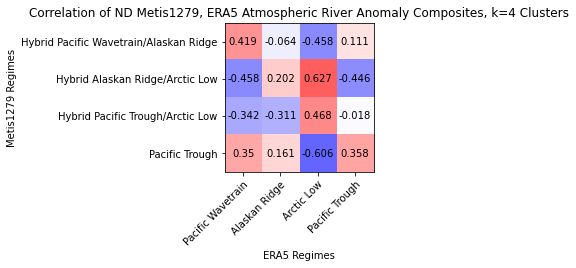

In [14]:
#Plot the matrix
fig, ax = plt.subplots()

#Color the corresponding box accordingly
im = ax.imshow(da_pattmetis, cmap='bwr', vmax = 1, vmin = -1)

#Label ERA5 ticks with regime names
ax.set_xticklabels(cluster_names)
ax.set_yticklabels(titles)

# Rotate the x tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

#Show the ticks
ax.set_xticks(np.arange(k))
ax.set_yticks(np.arange(k))

#Label the x and y axes
plt.xlabel('ERA5 Regimes')

if era5_comp == False:
    plt.ylabel('Metis' + res + ' Regimes')
else:
    plt.xlabel('ERA5 ' + months + ' Regimes')
    plt.ylabel('ERA5 ' + era_months + ' Regimes')

#Print the correlation out to 3rd decimal place as text
for i in np.arange(0,k):
    for j in np.arange(0,k):
        text = ax.text(j, i, round(da_pattmetis.values[i, j],3),
                       ha="center", va="center", color='k')

# Set the title
if era5_comp == False:
    ax.set_title("Correlation of " + months + " Metis" + res + ", ERA5 Atmospheric River Anomaly Composites, k=" 
             + str(k) + " Clusters")
else:
    ax.set_title("Correlation of " + era_months + " ERA5, " + months + " ERA5 Atmospheric River Anomaly Composites, k=" 
             + str(k) + " Clusters")

fig.tight_layout()
plt.savefig(f_corr, bbox_inches = 'tight')

## Line plot of model correlation summary

In [15]:
# For each ERA5 regime:  model correlation of the most highest correlated model regime
ch = da_pattmetis.max('variable').values

# For each ERA5 regime: model correlation of the second most highest correlated model regime C2
c2 = []

# For each ERA5 regime: average all but the highest correlation to get CL
cl = []

# For each ERA5 regime: 
for cluster_k in np.arange(0,len(da_pattmetis.cluster)):
    c2.append((np.sort(da_pattmetis.values[:,cluster_k]))[-2])
    cl.append(np.mean(np.sort(da_pattmetis.values[:,cluster_k])[:-1]))

In [16]:
c2

[0.35031712086497674,
 0.1612396831217317,
 0.468224186813281,
 0.11089006101339528]

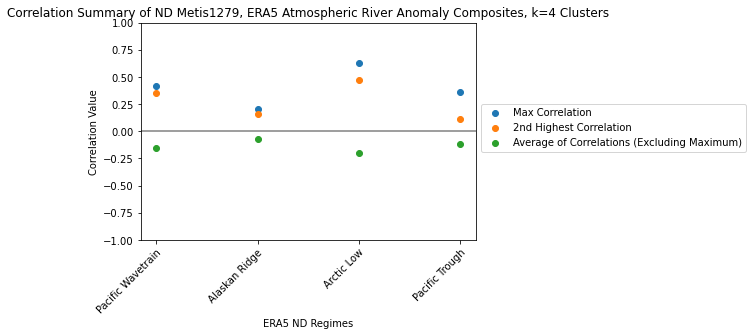

In [17]:
# Plot correlation measurements
plt.scatter(np.arange(0,len(da_pattmetis.cluster)), ch)
plt.scatter(np.arange(0,len(da_pattmetis.cluster)), c2)
plt.scatter(np.arange(0,len(da_pattmetis.cluster)), cl)

#Set y limits to [-1,1]
plt.ylim([-1,1])

#Put a legend on the plot
plt.legend(['Max Correlation', '2nd Highest Correlation', 'Average of Correlations (Excluding Maximum)'],
          bbox_to_anchor=(1,.65))

#Put a horizontal line at zero
plt.axhline(c='gray')

#Set number of x-ticks to the number of cluster
plt.xticks(da_pattmetis.cluster, labels = cluster_names, rotation=45, ha="right",
         rotation_mode="anchor")

# Rotate xtick labels
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

#Set x label
plt.xlabel('ERA5 ' + months + ' Regimes')

#Set y label
plt.ylabel('Correlation Value')

#Put a title on the plot
if era5_comp == False:
    plt.title("Correlation Summary of " + months + ' Metis' + res + 
          ", ERA5 Atmospheric River Anomaly Composites, k=" + str(k) + " Clusters")
else:
    plt.title("Correlation Summary of " + era_months + ' ERA5, ' + months + 
          " ERA5 Atmospheric River Anomaly Composites, k=" + str(k) + " Clusters")
plt.savefig(f_sum, bbox_inches = 'tight')